# Multi-Class Classification & Multi Label Classification Demonstrations

As a clothing retailer with an e-Commerce presence, it's important for us to understand what customers are saying about our products, which products are most popular with our customers, and how we can improve our offerings.



In [1]:
# Gereral Imports
import pandas as pd
import re
import string
from timeit import timeit
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline


# Model Persistence Imports
from joblib import dump, load

# Test Processing Imports
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer


# Plotting Imports
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing & EDA

Importing our dataset and providing the necessary cleaning and analysis.

In [2]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Department Name          23472 non-null  object
 7   Class Name               23472 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.4+ MB


In [4]:
df.shape

(23486, 8)

### Null Values

Nulll values are generally not desireable in a dataset.  In certain cases, observations (rows) with low counts will simply be dropped, in other cases, they can be filled with other values.

In [5]:
# fill the NA values with empty string so that we don't drop rows that are only missing a title
df['Title'].fillna('', inplace=True)

In [6]:
# count of nulls
df.isnull().sum()

Age                          0
Title                        0
Review Text                845
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Department Name             14
Class Name                  14
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [9]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

In [10]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

### Duplicates

A common practice is to review any duplicates.  If there are large quantities, they can skew the results.

In [11]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 22628
After = 22626

Total Removed = 2


## Check for Imbalanced Data

In [12]:
df['Department Name'].value_counts()

Tops        10048
Dresses      6145
Bottoms      3661
Intimate     1652
Jackets      1002
Trend         118
Name: Department Name, dtype: int64

In [13]:
filter = (df['Class Name'] == 'Chemises') | (df['Class Name'] == 'Casual bottoms')
df = df[~filter]

## Text Cleaning

For **Parts** of our analysis, the text needs to have some basic transformation for our models to work propertly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to there *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `simming` and `swimmer` will be reduced to `swim`.

**Note**: The orginal text will be preserved for other analysis.

In [14]:
df['Text'][1]

' Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [15]:
def process_string(text):
    
    final_string = ""
    
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove punctionation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words and usless words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub('\w*\d\w*', '', w) for w in text_filtered]
    
    # Stem the text with NLTK PorterStemmer
    stemmer = PorterStemmer() 
    text_stemmed = [stemmer.stem(y) for y in text_filtered]

    # Join the words back into a string
    final_string = ' '.join(text_stemmed)
    
    return final_string

In [16]:
df['Text_Processed'] = df['Text'].apply(lambda x: process_string(x))

In [17]:
df['Text_Processed'][1]

'love dress sooo pretti happen find store im glad bc never would order onlin bc petit bought petit  love length hit littl knee would definit true midi someon truli petit'

# Multiclass Classification Model:

## Pipeline Building

In [18]:
def create_pipe(clf):
    
    # Each pipeline uses the same column transformer.  
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(), 'Text_Processed'),
             ('Text Length', MinMaxScaler(), ['text_len'])],
            remainder='drop') 
    
    pipeline = Pipeline([('prep',column_trans),                     
                         ('clf', clf)])
     
    return pipeline

## Model Selection via Cross-Validation

In [19]:
X = df[['Text_Processed', 'text_len']]
y = df['Department Name']

In [20]:
y.value_counts()

Tops        10048
Dresses      6145
Bottoms      3660
Intimate     1651
Jackets      1002
Trend         118
Name: Department Name, dtype: int64

In [21]:
le = LabelEncoder()
y = le.fit_transform(y)
y.shape

(22624,)

In [22]:
le.classes_

array(['Bottoms', 'Dresses', 'Intimate', 'Jackets', 'Tops', 'Trend'],
      dtype=object)

## Model Training

In [23]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=53)

## Model Validation

In [24]:
def fit_and_print(pipeline, name):
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))
    
    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.YlGn)

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(name + '.png', dpi=300) 
    plt.show; 

              precision    recall  f1-score   support

           0      0.790     0.872     0.829      1193
           1      0.897     0.872     0.885      2037
           2      0.536     0.526     0.531       527
           3      0.593     0.746     0.661       315
           4      0.895     0.863     0.879      3361
           5      0.000     0.000     0.000        33

    accuracy                          0.834      7466
   macro avg      0.619     0.646     0.631      7466
weighted avg      0.837     0.834     0.835      7466

CPU times: user 2.44 s, sys: 1.07 s, total: 3.52 s
Wall time: 1.4 s


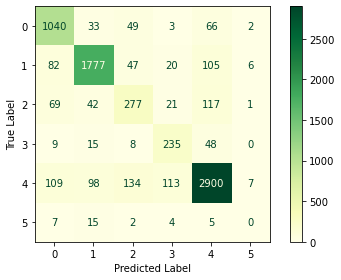

In [25]:
clf = OneVsRestClassifier(LogisticRegression(random_state=42, 
                         class_weight='balanced'))
pipeline = create_pipe(clf)
%time fit_and_print(pipeline, 'multiclass_2')

              precision    recall  f1-score   support

           0      0.798     0.844     0.820      1193
           1      0.912     0.843     0.876      2037
           2      0.436     0.584     0.499       527
           3      0.563     0.781     0.654       315
           4      0.900     0.827     0.862      3361
           5      0.011     0.030     0.016        33

    accuracy                          0.811      7466
   macro avg      0.603     0.652     0.621      7466
weighted avg      0.836     0.811     0.821      7466

CPU times: user 2.57 s, sys: 1.07 s, total: 3.64 s
Wall time: 1.5 s


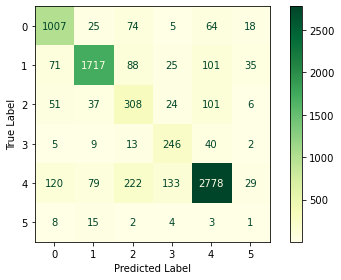

In [26]:
clf = OneVsOneClassifier(LogisticRegression(random_state=42, 
                         class_weight='balanced'))
pipeline = create_pipe(clf)
%time fit_and_print(pipeline, 'multiclass_3')

## Persist the Model

In [27]:
dump(pipeline, 'multiclass.joblib') 

['multiclass.joblib']

## Test on Custom Data

In [28]:
# Load the model
pipeline = load('multiclass.joblib')

In [29]:
def create_test_data(x):
    
    x = process_string(x)
    length = len(x)
    
    d = {'Text_Processed' : x,
        'text_len' : length}

    df = pd.DataFrame(d, index=[0])
    
    return df

In [30]:
revs = ['This dress is gorgeous and I love it.',
        'This skirt has really horible quality and I hate it!',
        'A super cute top with the perfect fit.',
        'The most gorgeous pair of jeans I have seen.',
        'this item is too little and tight.']

In [31]:
for rev in revs:
    c_res = pipeline.predict(create_test_data(rev))
    print(rev, '=', le.classes_[c_res[0]])

This dress is gorgeous and I love it. = Dresses
This skirt has really horible quality and I hate it! = Bottoms
A super cute top with the perfect fit. = Tops
The most gorgeous pair of jeans I have seen. = Bottoms
this item is too little and tight. = Intimate


## Multi-Label Classification

Next, we'll attempt to create a Supervised Machine Learning model to classify products by Department.  This process looks at the text that a user wrote in a review and determined its Department.

An interesting opportunity is to use this information to **cross-sell** or **cross-list** products.  If there is a strong enough probability that an item could be in multiple departments from our analysis, could we **increase sales** with cross-marketing?

In [32]:
# Tokenize the words
df['Class Name'] = df['Class Name'].apply(word_tokenize)

In [33]:
X = df[['Text_Processed', 'Department Name']]
y = df['Class Name']

In [34]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [35]:
print(y)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [36]:
mlb.classes_

array(['Blouses', 'Dresses', 'Fine', 'Intimates', 'Jackets', 'Jeans',
       'Knits', 'Layering', 'Legwear', 'Lounge', 'Outerwear', 'Pants',
       'Shorts', 'Skirts', 'Sleep', 'Sweaters', 'Swim', 'Trend', 'gauge'],
      dtype=object)

In [37]:
def create_pipe(clf):
    
    # Create the column transfomer
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(), 'Text_Processed'),
             ('Categories', OneHotEncoder(handle_unknown="ignore"), 
              ['Department Name'])],
            remainder='drop') 
    
    # Build the pipeline
    pipeline = Pipeline([('prep',column_trans),
                         ('clf', clf)])
     
    return pipeline

## Model Building & Validation

In [38]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=1)

In [39]:
print(y_train.shape)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(15158, 19)
(15158, 2)
(7466, 2)
(7466, 19)


In [40]:
clf = MultiOutputClassifier(LogisticRegression(max_iter=500, random_state=42))

pipeline = create_pipe(clf)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score = metrics.f1_score(y_test, y_pred, average='macro', zero_division=0)

print(metrics.classification_report(y_test, y_pred, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.691     0.420     0.523       973
           1      1.000     1.000     1.000      1996
           2      0.544     0.087     0.150       355
           3      1.000     0.019     0.036        54
           4      0.784     0.969     0.867       229
           5      0.943     0.676     0.788       340
           6      0.712     0.662     0.686      1562
           7      0.500     0.022     0.042        46
           8      1.000     0.174     0.296        46
           9      0.708     0.568     0.630       213
          10      0.875     0.393     0.542       107
          11      0.847     0.683     0.756       463
          12      0.765     0.263     0.391        99
          13      1.000     0.808     0.894       312
          14      1.000     0.039     0.076        76
          15      0.711     0.404     0.516       445
          16      0.958     0.590     0.730       117
          17      1.000    

In [41]:
# Retreive the text lables from the MultiLabelBinarizer
pred_labels = mlb.inverse_transform(y_pred)

# Append them to the DataFrame
X_test['Predicted Labels'] = pred_labels

In [42]:
pd.set_option('display.max_colwidth', 25)
filter = X_test['Predicted Labels'].apply(lambda x: len(x) > 1)
df_mo = X_test[filter]
df_mo.sample(10, random_state=24)

,Text_Processed,Department Name,Predicted Labels
12561,cute summer blous top...,Tops,"(Blouses, Knits)"
15309,awesom poncho back ev...,Tops,"(Fine, gauge)"
6672,great sweater true fo...,Tops,"(Fine, Sweaters, gauge)"
4446,love top love fabric ...,Tops,"(Blouses, Knits)"
10397,love alway pilcro pan...,Bottoms,"(Jeans, Pants)"
14879,love shirt perfect fi...,Tops,"(Blouses, Knits)"
5948,simpl stylish top jea...,Tops,"(Blouses, Knits)"
16643,tri youll love beauti...,Tops,"(Fine, Sweaters, gauge)"
17866,qualiti sweater beaut...,Tops,"(Fine, Sweaters, gauge)"
22163,cute top got top mail...,Tops,"(Blouses, Knits)"
